In [1]:

import datetime as dt
import warnings

import numpy as np
import pandas as pd
from scipy import signal
from scipy.signal import find_peaks
from sklearn.ensemble import IsolationForest

#--- Need Plotly for plotting-------------
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/store-sales-time-series-forecasting/oil.csv
/kaggle/input/store-sales-time-series-forecasting/sample_submission.csv
/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv
/kaggle/input/store-sales-time-series-forecasting/stores.csv
/kaggle/input/store-sales-time-series-forecasting/train.csv
/kaggle/input/store-sales-time-series-forecasting/test.csv
/kaggle/input/store-sales-time-series-forecasting/transactions.csv


In [2]:
oilprice= pd.read_csv('../input/store-sales-time-series-forecasting/oil.csv')
holiday = pd.read_csv('../input/store-sales-time-series-forecasting/holidays_events.csv')
train = pd.read_csv('../input/store-sales-time-series-forecasting/train.csv')
transactions = pd.read_csv('../input/store-sales-time-series-forecasting/transactions.csv')
stores= pd.read_csv('../input/store-sales-time-series-forecasting/stores.csv')

# preprocessing
*Oil Price*

In [3]:
oilprice_df = oilprice.fillna(method='bfill')

*Holiday*

In [4]:
holiday['isHoliday']=1
holiday.rename(columns={'type' : 'holidayType'}, inplace=True)
holiday_df = holiday[['date','isHoliday','holidayType']]

*train*

In [5]:
train.drop('id', axis=1,inplace=True)
df = pd.merge(train, holiday_df, on='date', how='left')
df.loc[df['isHoliday'].isna(), 'holidayType'] = 'Not_holiday'

df.loc[df['isHoliday'].isna(), 'isHoliday'] = 0


In [6]:
df = pd.merge(df, oilprice, on='date', how='left')
df['dcoilwtico'].fillna(method='bfill', inplace=True)

#### let's explore data a bit :)

In [7]:

temp  = df.groupby('date')[['sales','dcoilwtico','isHoliday']].agg({'sales':'sum', 'dcoilwtico':'mean' , 'isHoliday':'max'})

In [8]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(
    go.Scatter(x=temp.index, y=temp.sales, name="sales", mode="markers"),
    secondary_y=False
)
fig.add_trace(
    go.Scatter(x=temp.index, y=temp.dcoilwtico, name="WTI oil price", mode="lines"),
    secondary_y=True, 
)
fig.add_trace(
    go.Scatter(x=temp[temp['isHoliday']==1].index, 
               y=temp['isHoliday'][temp['isHoliday']==1] * temp['sales'][temp['isHoliday']==1], name="Holiday", mode="markers"),
    secondary_y=False, 
)
fig.update_xaxes(title_text="Date")
fig.update_yaxes(title_text="Sales", secondary_y=False)
fig.update_yaxes(title_text="WTI oil price", secondary_y=True)

##### earthquake struck Ecuador on April 16, 2016. People rallied in relief efforts donating water and other first need products which greatly affected supermarket sales for several weeks after the earthquake. It seems some outliers exist in our data lets remove this by the help of the Isolation forest. 

In [9]:
model=IsolationForest(n_estimators=50, max_samples='auto', contamination=float(0.1),max_features=1.0)
model.fit(temp['sales'].values.reshape(-1,1))

IsolationForest(contamination=0.1, n_estimators=50)

In [10]:
temp['anomaly'] = model.decision_function(temp['sales'].values.reshape(-1,1))
temp['anomaly'] = np.where( temp['anomaly'] <0, 'outlier' , 'normal')


In [11]:
px.histogram(temp , x='sales',color='anomaly', marginal='box')

In [12]:
possible_outlier_days= temp[temp['anomaly']=='outlier'].index

In [13]:
stores.rename(columns={'type' : 'storeType'}, inplace = True)
stores_df= stores[['store_nbr' ,'storeType','city','cluster']]

In [14]:
df = pd.merge(df, stores_df, on='store_nbr', how='left')

#since we do not have transactions on the test set, so it is better to remove the transactions from the train set:(
# df = pd.merge(df, transactions, on=['store_nbr','date'], how='left')


In [15]:
# df['transactions'].fillna(0, inplace=True)

In [16]:
df

,date,store_nbr,family,sales,onpromotion,isHoliday,holidayType,dcoilwtico,storeType,city,cluster
0,2013-01-01,1,AUTOMOTIVE,0.000,0,1.0,Holiday,93.14,D,Quito,13
1,2013-01-01,1,BABY CARE,0.000,0,1.0,Holiday,93.14,D,Quito,13
2,2013-01-01,1,BEAUTY,0.000,0,1.0,Holiday,93.14,D,Quito,13
3,2013-01-01,1,BEVERAGES,0.000,0,1.0,Holiday,93.14,D,Quito,13
4,2013-01-01,1,BOOKS,0.000,0,1.0,Holiday,93.14,D,Quito,13
...,...,...,...,...,...,...,...,...,...,...,...
3054343,2017-08-15,9,POULTRY,438.133,0,1.0,Holiday,47.57,B,Quito,6
3054344,2017-08-15,9,PREPARED FOODS,154.553,1,1.0,Holiday,47.57,B,Quito,6
3054345,2017-08-15,9,PRODUCE,2419.729,148,1.0,Holiday,47.57,B,Quito,6
3054346,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,1.0,Holiday,47.57,B,Quito,6


we can see in the sum 

In [17]:
px.imshow(df.corr())

In [18]:
df.isna().sum()

date           0
store_nbr      0
family         0
sales          0
onpromotion    0
isHoliday      0
holidayType    0
dcoilwtico     0
storeType      0
city           0
cluster        0
dtype: int64

In [19]:
from sklearn.preprocessing import OrdinalEncoder

encoder_holidays = OrdinalEncoder()
encoder_holidays.fit(df['holidayType'].values.reshape(-1,1))
df['holidayType'] = encoder_holidays.transform(df['holidayType'].values.reshape(-1,1))



In [20]:
encoder_family = OrdinalEncoder()
encoder_family.fit(df['family'].values.reshape(-1,1))
df['family'] = encoder_family.transform(df['family'].values.reshape(-1,1))

In [21]:

encoder_storeType = OrdinalEncoder()
encoder_storeType.fit(df['storeType'].values.reshape(-1,1))
df['storeType'] = encoder_storeType.transform(df['storeType'].values.reshape(-1,1))


In [22]:

encoder_city = OrdinalEncoder()
encoder_city.fit(df['city'].values.reshape(-1,1))
df['city'] = encoder_city.transform(df['city'].values.reshape(-1,1))

In [23]:
df

,date,store_nbr,family,sales,onpromotion,isHoliday,holidayType,dcoilwtico,storeType,city,cluster
0,2013-01-01,1,0.0,0.000,0,1.0,3.0,93.14,3.0,18.0,13
1,2013-01-01,1,1.0,0.000,0,1.0,3.0,93.14,3.0,18.0,13
2,2013-01-01,1,2.0,0.000,0,1.0,3.0,93.14,3.0,18.0,13
3,2013-01-01,1,3.0,0.000,0,1.0,3.0,93.14,3.0,18.0,13
4,2013-01-01,1,4.0,0.000,0,1.0,3.0,93.14,3.0,18.0,13
...,...,...,...,...,...,...,...,...,...,...,...
3054343,2017-08-15,9,28.0,438.133,0,1.0,3.0,47.57,1.0,18.0,6
3054344,2017-08-15,9,29.0,154.553,1,1.0,3.0,47.57,1.0,18.0,6
3054345,2017-08-15,9,30.0,2419.729,148,1.0,3.0,47.57,1.0,18.0,6
3054346,2017-08-15,9,31.0,121.000,8,1.0,3.0,47.57,1.0,18.0,6


In [24]:
df_clean = df[~df['date'].isin(possible_outlier_days)].copy()

In [25]:
from sklearn.model_selection import train_test_split


df_clean['date'] = pd.to_datetime(df_clean['date'])
df_clean['dayoftheWeek'] = df_clean['date'].apply(lambda x: x.isoweekday())
df_clean['month'] = df_clean['date'].apply(lambda x: x.month)

y = df_clean['sales'] 
df_clean.drop(['sales','date'], axis=1, inplace=True)
X= df_clean


In [26]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2)

In [27]:
from sklearn.ensemble import RandomForestRegressor
RandomForest = RandomForestRegressor(n_estimators = 10)
RandomForest.fit(X_train,y_train)
RandomForest.score(X_test,y_test)

0.9469770361821521

## Let's take the model predict the test set

In [28]:
test = pd.read_csv('../input/store-sales-time-series-forecasting/test.csv')

In [29]:
ids= test['id'].astype(str).copy()
test.drop('id',axis=1,inplace=True)

In [30]:
df_test = pd.merge(test, holiday_df, on='date', how='left')
df_test.loc[df_test['isHoliday'].isna(), 'holidayType'] = 'Not_holiday'
df_test.loc[df_test['isHoliday'].isna(), 'isHoliday'] = 0

In [31]:
df_test = pd.merge(df_test, oilprice, on='date', how='left')
df_test['dcoilwtico'].fillna(method='bfill', inplace=True)

In [32]:
df_test = pd.merge(df_test, stores_df, on='store_nbr', how='left')
# df_test = pd.merge(df_test, transactions, on=['store_nbr','date'], how='left')

In [33]:
# df_test['transactions'].fillna(0, inplace=True)

In [34]:
df_test['holidayType'] = encoder_holidays.transform(df_test['holidayType'].values.reshape(-1,1))

In [35]:
df_test['family'] = encoder_family.transform(df_test['family'].values.reshape(-1,1))

In [36]:
df_test['storeType'] = encoder_storeType.transform(df_test['storeType'].values.reshape(-1,1))

In [37]:
df_test['city'] = encoder_city.transform(df_test['city'].values.reshape(-1,1))

In [38]:
df_test['date'] = pd.to_datetime(df_test['date'])
df_test['dayoftheWeek'] = df_test['date'].apply(lambda x: x.isoweekday())
df_test['month'] = df_test['date'].apply(lambda x: x.month)

In [39]:


sales_test= RandomForest.predict(df_test.drop('date',axis=1))

In [40]:
df_test['sales']  = sales_test
df_test['id'] = ids

In [41]:
df_test[['id','sales']].set_index('id').to_csv('submit.csv')

<AxesSubplot:>

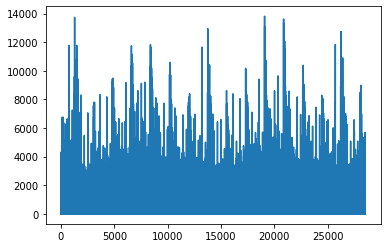

In [42]:
df_test['sales'].plot()